# Predicting Car Prices

The goal of this project is to practice machine learning workflow by predicting car prices using dataset containing car characteristics. The dataset comes from the UCI's machine learning [repository](https://archive.ics.uci.edu/ml/datasets/automobile).

**Disclaimer:** This project is part of the guided project for a Data Scientist Path on dataquest.io.

## Introduction

Let's first read the dataset and explore it to get a better understanding of it. Since the original dataset doesn't have column headers in it, we need to provide the list manually.

The numeric feature columns in the dataset are:
* normalized-losses
* wheel-base
* length
* width
* height
* curb-weight
* engine-type
* num-of-cylinders
* engine-size
* bore
* stroke
* compression-rate
* horsepower
* peak-rpm
* city-mpg
* highway-mpg
    
The target column is `price`.

In [17]:
# import necessary libraries
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# enable pandas to show all columns
pd.options.display.max_columns = 99


# list of columns names
columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
           'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
           'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders',
           'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower',
           'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# read the dataset
cars = pd.read_csv("imports-85.data", names=columns)

# check first few values
cars.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [18]:
# check columns and observations
cars.shape

(205, 26)

## Data Cleaning

Machine Learning algorithms can't treat missing values on their own. For that reason we need to treat missing values. From the output above we immediately can see that `normalized-losses` column contains missing values in the form of "?". We need to first replace "?" values with `numpy.nan` across the dataset. This will help us to easier convert other columns to required datatypes.

In [19]:
# replace ? values with np.nan
cars = cars.replace("?", np.nan)

In [20]:
# check datatypes
cars.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-rate     float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

Now that we have replaced the "?" values, let's convert columns containing `int` or `float` values to their correct data type

In [21]:
# list of columns to convert
cols = ["normalized-losses","bore","stroke","horsepower","peak-rpm","price"]

# convert the values to their appropriate datatype
for col in cols:
    cars[col] = pd.to_numeric(cars[col], errors='coerce')

Rerun the datatypes cell to check if the conversion was successful.

Now let's look at the columns which have these missing values and decide on how to handle them.

In [22]:
# Check for missing values
cars.isnull().sum()

symboling             0
normalized-losses    41
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

We can see that there are 41 null values out of 205 total records in `normalized-losses`. The missing values are 25% of all records. To handle this column entirely we can fill the missing values with the average value or drop the column entirely. We won't remove the missing rows since this is a big part of the dataset. To decide on this, let's check the distribution of values in the `normalized-losses`.

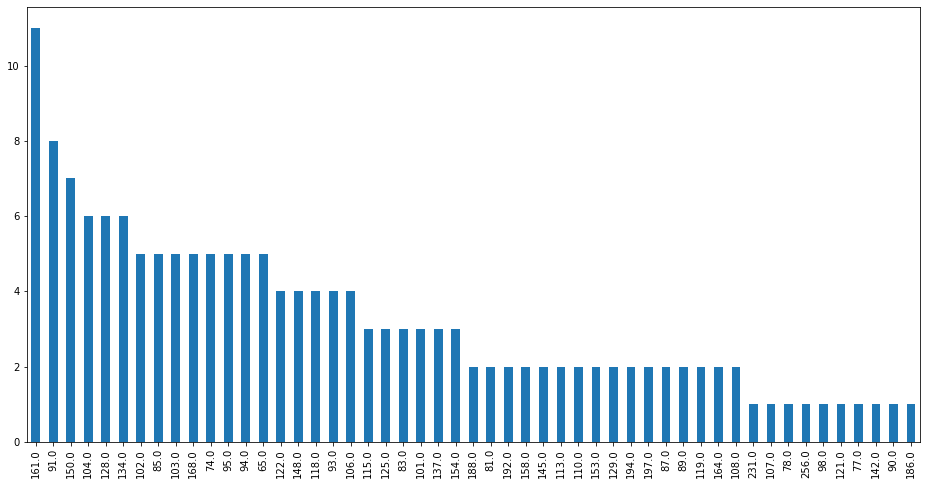

In [23]:
cars['normalized-losses'].value_counts().plot(kind='bar', figsize=(16,8))

We can see that the distribution for this column is right skewed. Thus we won't be imputing using average since this might skew our results and introduce bias into this column. One potential solution would be to use mean imputation after normalizing the column, which we will do.

In [24]:
# normalize the column
cars['normalized-losses'] = (cars['normalized-losses'] - cars['normalized-losses'].mean()) / cars['normalized-losses'].std()

# impute with average value
cars['normalized-losses'].fillna(cars['normalized-losses'].mean(), inplace=True)

Rerun, the cell showing missing values to ensure that the imputation was successful. We can also observe that there are few missing values for columns such as `price`, `horsepower`, `peak-rpm`, `bore` and `stroke`. We will also normalize them and impute with average value.

In [25]:
# columns to be treated as per above
cols = ['bore', 'stroke', 'peak-rpm', 'horsepower', 'price']

# normalize and fill missing values
for col in cols:
    cars[col] = (cars[col] - cars[col].mean()) / cars[col].std()
    cars[col].fillna(cars[col].mean(), inplace=True)

Rerun the cell generating null value count and make sure they are treated.

## Univariate Model

Now let's start with a univariate k-nearest neighbors model as part of our project for predicting car prices. Starting with simple models before moving to more complex models helps us structure your code workflow and understand the features better.

To enhance and simplify our model testing workflow, we will create a function that encapsulates the training and simple validation process.

In [26]:
# function to knn_model training and validation
def knn_train_test(train_name, target_name, data):
    # make a copy of the dataset
    df = data.copy()
    
    # number of observations for split
    obs = int(df.shape[0] / 2)
    
    # split the data into train and test
    train_df = df.iloc[:obs]
    test_df = df.iloc[obs:]
    
    # reshape the values since we have a single feature
    train_data = train_df[train_name].values.reshape(-1, 1)
    test_data = test_df[train_name].values.reshape(-1, 1)
    
    # instantiate  and fit the model
    knn = KNeighborsRegressor()
    knn.fit(train_data, train_df[target_name])
    
    # make predictions and evaluate
    preds = knn.predict(test_data)
    rmse = mean_squared_error(test_df[target_name], preds) ** (1/2)
    
    return rmse

In [27]:
# use the function to train a model on normalized-losses
knn_train_test('normalized-losses', 'price', cars)

1.0768788918340664

Resulting rmse is based on the model that uses only one feature `normalized-losses`. We can test additional features to see how our model performs.

In [28]:
# use numeric features
numeric_features = ['wheel-base', 'length', 'width', 'height',
                    'curb-weight', 'engine-size', 'compression-rate',
                    'city-mpg', 'highway-mpg', 'horsepower', 'peak-rpm']

# loop through models with individual feature
for col in numeric_features:
    result = knn_train_test(col, 'price', cars)
    print("RMSE for model with {}: {}".format(col, result))

RMSE for model with wheel-base: 1.214252890227465
RMSE for model with length: 1.1107969135114395
RMSE for model with width: 0.8581184488064216
RMSE for model with height: 1.3712276576274274
RMSE for model with curb-weight: 0.7526797743700095
RMSE for model with engine-size: 0.6066522674323407
RMSE for model with compression-rate: 0.9980929742948769
RMSE for model with city-mpg: 0.6071818370617673
RMSE for model with highway-mpg: 0.5904065996733864
RMSE for model with horsepower: 0.6212450466337898
RMSE for model with peak-rpm: 1.1696138374863996


While the models above are not indicative of performance, but it seems that model with `city-mpg` feature has the lowest error on the model.

Next, let's modify our function to accept a `k` parameter and rerun our univariate model with the above features to see the performance. We will use k values of `1`, `3`, `5`, `7` and `9` to see which model performs well.

In [29]:
# function to knn_model training and validation - modified 
def knn_train_test(train_name, target_name, data, k=5):
    # make a copy of the dataset
    df = data.copy()
    
    # number of observations for split
    obs = int(df.shape[0] / 2)
    
    # split the data into train and test
    train_df = df.iloc[:obs]
    test_df = df.iloc[obs:]
    
    # reshape the values since we have a single feature
    train_data = train_df[train_name].values.reshape(-1, 1)
    test_data = test_df[train_name].values.reshape(-1, 1)
    
    # instantiate  and fit the model
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_data, train_df[target_name])
    
    # make predictions and evaluate
    preds = knn.predict(test_data)
    rmse = mean_squared_error(test_df[target_name], preds) ** (1/2)
    
    return rmse

In [30]:
# use numeric features
numeric_features = ['wheel-base', 'length', 'width', 'height',
                    'curb-weight', 'engine-size', 'compression-rate',
                    'city-mpg', 'highway-mpg', 'horsepower', 'peak-rpm']

# dictionary to store model results
lowest_rmse = {}

# loop through models with individual feature
for col in numeric_features:
    for k in [1,3,5,7,9]:
        result = knn_train_test(col, 'price', cars, k=k)
        lowest_rmse[(col, k)] = result

lowest_rmse

{('wheel-base', 1): 1.0200915246848115,
 ('wheel-base', 3): 1.1330559244770682,
 ('wheel-base', 5): 1.214252890227465,
 ('wheel-base', 7): 1.1050644625745172,
 ('wheel-base', 9): 1.0706582345927034,
 ('length', 1): 1.2582151367719674,
 ('length', 3): 1.164040684899018,
 ('length', 5): 1.1107969135114395,
 ('length', 7): 1.0788091491246363,
 ('length', 9): 0.9649699176225501,
 ('width', 1): 1.173235330629889,
 ('width', 3): 0.776724402613776,
 ('width', 5): 0.8581184488064216,
 ('width', 7): 0.7920962270887307,
 ('width', 9): 0.7818084447558675,
 ('height', 1): 1.835270961051065,
 ('height', 3): 1.4522475457196613,
 ('height', 5): 1.3712276576274274,
 ('height', 7): 1.2536105424726978,
 ('height', 9): 1.1799262400433599,
 ('curb-weight', 1): 0.8977925627200231,
 ('curb-weight', 3): 0.7810203611189004,
 ('curb-weight', 5): 0.7526797743700095,
 ('curb-weight', 7): 0.7273112573379618,
 ('curb-weight', 9): 0.6962953604831444,
 ('engine-size', 1): 0.711130777393697,
 ('engine-size', 3): 0.66

We can observe that there are multiple univariate models with low rmse. Nevertheles, we can find out the one with smallest rmse.

In [31]:
# find the feature and k with minimum rmse
minval = min(lowest_rmse.values())
res = [k for k, v in lowest_rmse.items() if v == minval]

print("Model with lowest rmse is based on feature:{} with k={}".format(res[0][0], res[0][1]))

Model with lowest rmse is based on feature:highway-mpg with k=9


## Multivariate Model

Let's modify the function we wrote to work with multiple columns.

In [32]:
# function to knn_model training and validation
# modified for multivariate modeling
def knn_train_test(train_name, target_name, data, k=5):
    # make a copy of the dataset
    df = data.copy()
    
    # number of observations for split
    obs = int(df.shape[0] / 2)
    
    if len(train_name) <= 1:
        return "Please provide a list of features"
    
    # split the data into train and test
    train_df = df.iloc[:obs]
    test_df = df.iloc[obs:]
    
    # instantiate  and fit the model
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(train_df[train_name], train_df[target_name])
    
    # make predictions and evaluate
    preds = knn.predict(test_df[train_name])
    rmse = mean_squared_error(test_df[target_name], preds) ** (1/2)
    
    return rmse

To test our new function, we will choose the best 2, 3, 4, 5 and 6 features sequentially from the univariate model exploration and train using the default value of k=5.

In [33]:
# features ordered by performance from univariate modeling
features = ['highway-mpg', 'horsepower', 'engine-size',
            'city-mpg', 'curb-weight']

# starting feature set
cols = features[:1]

# iterate and add each feature to the next model
for col in features:
    # add the next feature
    cols.append(col)
    
    # train the model
    res = knn_train_test(cols, 'price', cars)
    
    # print the rmse
    print("The model with {} features has rmse:{}".format(cols,res))

The model with ['highway-mpg', 'highway-mpg'] features has rmse:0.5904065996733864
The model with ['highway-mpg', 'highway-mpg', 'horsepower'] features has rmse:0.6622571328368921
The model with ['highway-mpg', 'highway-mpg', 'horsepower', 'engine-size'] features has rmse:0.5902520717106036
The model with ['highway-mpg', 'highway-mpg', 'horsepower', 'engine-size', 'city-mpg'] features has rmse:0.5614448491361091
The model with ['highway-mpg', 'highway-mpg', 'horsepower', 'engine-size', 'city-mpg', 'curb-weight'] features has rmse:0.7406898108805515


We can observe from the results above that the model with 5 features has the best rmse.

## Hyperparameter Tuning

Last, but not least, we will perform hyperparameter tuning in order to find the best `k` parameter for our top 3 models from the last section. We will visualize the hyperparameter tuning for each model in order to find out the optimal set.

In [34]:
# list of features of top models
model1 = ['highway-mpg', 'highway-mpg', 'horsepower', 'engine-size', 'city-mpg']
model2 = ['highway-mpg', 'highway-mpg']
model3 = ['highway-mpg', 'highway-mpg', 'horsepower', 'engine-size']

# dataframe to hold the results
results = []

# iterate through various k values
for k in range(1,25):

    # calculate the rmse for models
    res1 = knn_train_test(model1, 'price', cars, k=k)
    res2 = knn_train_test(model2, 'price', cars, k=k)
    res3 = knn_train_test(model3, 'price', cars, k=k)
    
    # save the results to the df
    results.append(['model1', k, res1])
    results.append(['model2', k, res2])
    results.append(['model3', k, res3])
    
# convert list of list to df
df = pd.DataFrame(results, columns=['model', 'k', 'score'])

In [35]:
df.dtypes

model     object
k          int64
score    float64
dtype: object

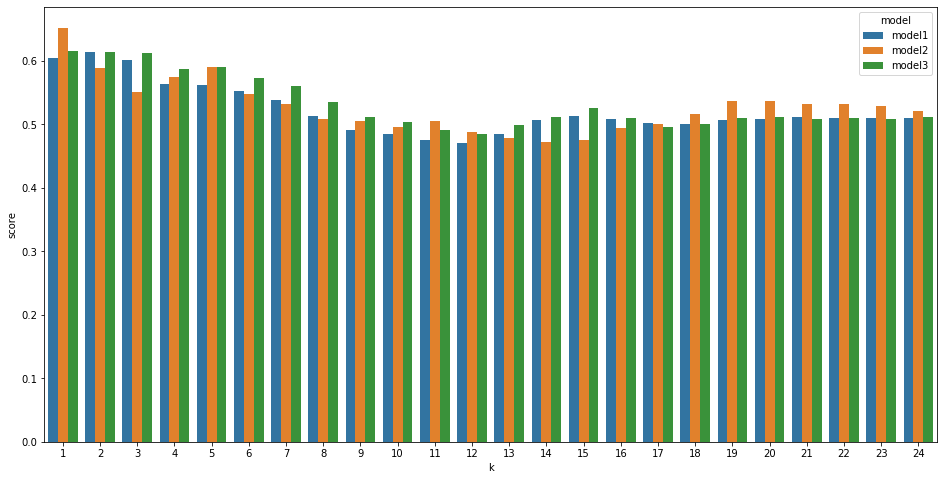

In [37]:
# visualize the results
import seaborn as sns
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(x='k', y='score', hue='model', data=df)
plt.show()

The bar chart displays the rmse for each model across k values. We can observe that model 2 has lower rmse consistently but all three models have lower rmse around k=12-14. We can also see that past k values of 15 the rmse started going up again and this indicates that our models started to overfit in for those k values. Nevertheless, k values around 12-14 seem like a good choice for the k parameter.

## Summary & Ideas

In this project we build a knn classifier and trained both univariate and multivariate models with varying k values. Some ideas on improving our function are implementing k-fold cross validations since currently we are using half of the data to train and the other half for testing, we could improve the performance and accuracy of the model by implementing k-fold cross validation and choose the k value just as we did with k value for knn.

That's it for this project. Feel free to leave your feedback and comments here below.